In [4]:
#importing dependencies

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D,  Flatten, Dense, Dropout, LSTM, SpatialDropout1D, Bidirectional

In [5]:
#Load and explore the spam data
file = 'emaildataset.csv'
messages = pd.read_csv(file, sep =',',names=["message", "label"])
messages[:3]

,message,label
0,Subject: naturally irresistible your corporate...,spam
1,Subject: the stock trading gunslinger fanny i...,spam
2,Subject: unbelievable new homes made easy im ...,spam


In [6]:
messages.describe()

,message,label
count,5728,5728
unique,5695,2
top,"Subject: re : i am zhendong zhendong , thank...",ham
freq,2,4360


In [7]:
duplicatedRow = messages[messages.duplicated()]
print(duplicatedRow[:5])

                                                message label
2155  Subject: research allocations to egm  hi becky...   ham
2260  Subject: departure of grant masson  the resear...   ham
2412  Subject: re : schedule and more . .  jinbaek ,...   ham
2473  Subject: day off tuesday  stinson ,  i would l...   ham
2763  Subject: re : your mail  zhendong ,  dr . kami...   ham


In [8]:
messages.groupby('label').describe().T

label                                                         ham  \
message count                                                4360   
        unique                                               4327   
        top     Subject: hello from enron  dear dr . mcmullen ...   
        freq                                                    2   

label                                                        spam  
message count                                                1368  
        unique                                               1368  
        top     Subject: fw : keep it under wraps , but this o...  
        freq                                                    1

In [9]:
# get all the ham and spam emails
ham_msg = messages[messages.label =='ham']
spam_msg = messages[messages.label=='spam']

# For ham and spam messages, create numpy list to visualize using wordcloud
ham_msg_text = " ".join(ham_msg.message.to_numpy().tolist())
spam_msg_text = " ".join(spam_msg.message.to_numpy().tolist())

In [10]:
ham_msg_text[:1000]

'Subject: hello guys ,  i \' m " bugging you " for your completed questionnaire and for a one - page  bio / statement on your thoughts on " business edu and the new economy " . if  my records are incorrect please re - ship your responses to me . i want to  put everything together next week so that i can ship it back to everyone .  the questionnaire is attached as well as copies of the bio pages for  michael froehls and myself ( two somewhat different approaches ) . the idea  of the latter is just to introduce yourself to the other panelists and give  them some background on how you are approaching the issues we will discuss .  we will also provide copies to the attendees and use this material for our  personal introductions at the opening of the panel discussions .  thanks and i look forward to seeing you in two weeks .  john  - waco _ background _ mf . doc  - jmartinbiosketch . doc  - questionnaire . doc  john d . martin  carr p . collins chair in finance  finance department  baylor u

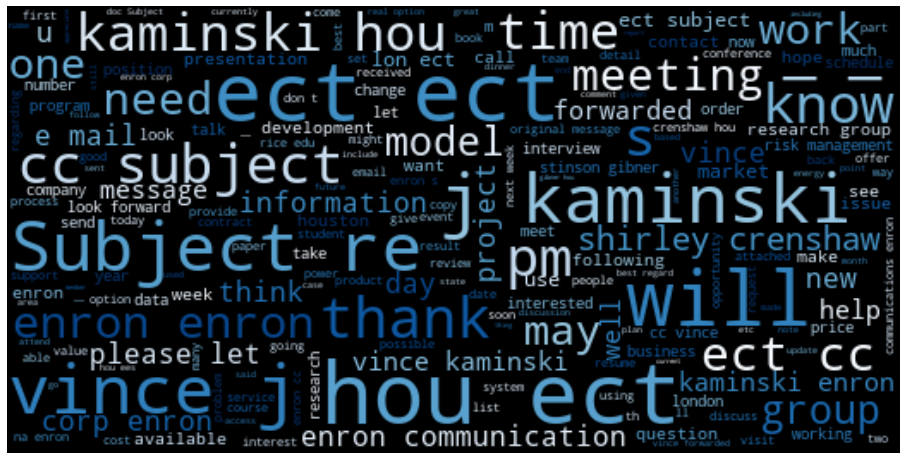

In [11]:
# wordcloud of ham messages
ham_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, 
                          background_color ="black", colormap='Blues').generate(ham_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

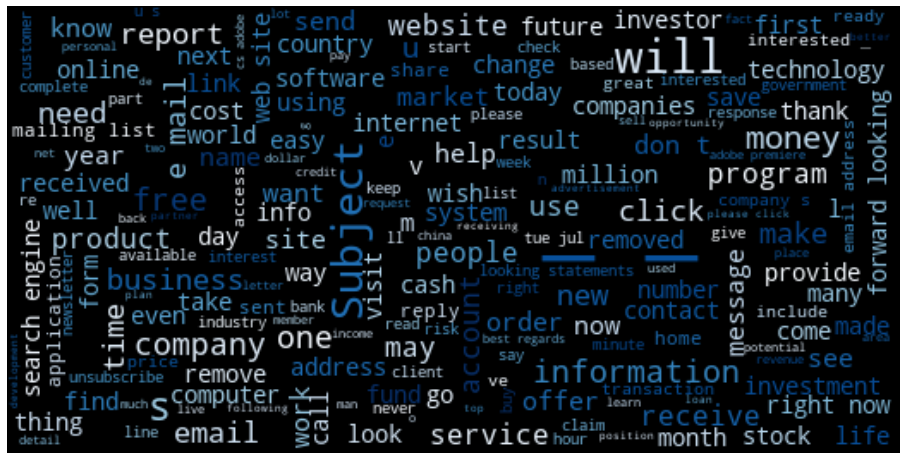

In [12]:
# wordcloud of spam messages
spam_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, 
                          background_color ="black", colormap='Blues').generate(spam_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

/srv/conda/envs/notebook/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Distribution of ham and spam email messages')

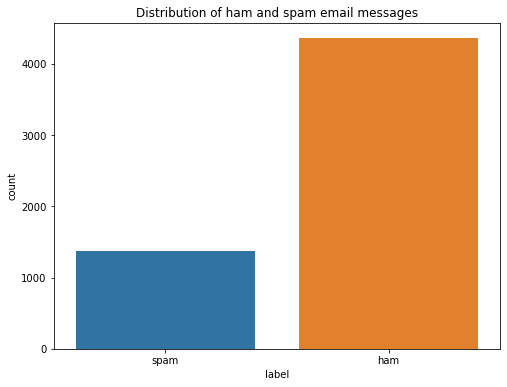

In [13]:
# we can observe imbalance data here. 
plt.figure(figsize=(8,6))
sns.countplot(messages.label)
plt.title('Distribution of ham and spam email messages')

In [14]:
# Percentage of spam messages
(len(spam_msg)/len(ham_msg))*100

31.376146788990827

In [15]:
# one way to fix it is to downsample the ham msg
ham_msg_df = ham_msg.sample(n = len(spam_msg), random_state = 45)
spam_msg_df = spam_msg

In [16]:
print(ham_msg_df.shape, spam_msg_df.shape)

(1368, 2) (1368, 2)


In [17]:
# Create a dataframe with ham and spam msgs
msg_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)

/srv/conda/envs/notebook/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Message types')

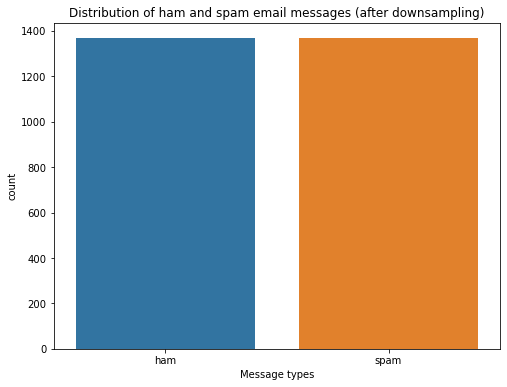

In [18]:
plt.figure(figsize=(8,6))
sns.countplot(msg_df.label)
plt.title('Distribution of ham and spam email messages (after downsampling)')
plt.xlabel('Message types')

In [19]:
# Get length column for each text
msg_df['text_length'] = msg_df['message'].apply(len)

#Calculate average length by label types
labels = msg_df.groupby('label').mean()
labels

,text_length
label,
ham,1633.490497
spam,1317.257310


In [20]:
#msg_df['msg_type']= msg_df['label'].apply(lambda x: 1 if x =='spam' else 0)
msg_df['msg_type']= msg_df['label'].map({'ham': 0, 'spam': 1})
msg_label = msg_df['msg_type'].values

In [21]:
# Split data into train and test
train_msg, test_msg, train_labels, test_labels = train_test_split(msg_df['message'], msg_label, test_size=0.2, random_state=434)

In [22]:
# Defining pre-processing hyperparameters
max_len = 50 # pad_sequencs parameter, it idicates we are only going to look for 50 words in a sentence
trunc_type = "post" # pad_sequences parameter
padding_type = "post" # pad_sequences parameter
oov_tok = "<OOV>" # out of vocabulary token
vocab_size = 500

In [23]:
max_len - 100

-50

In [24]:
max_len = 200

In [25]:
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(train_msg)

In [26]:
# Get the word_index
word_index = tokenizer.word_index
word_index

{'<OOV>': 1,
 'the': 2,
 'to': 3,
 'and': 4,
 'of': 5,
 'a': 6,
 'you': 7,
 'in': 8,
 'for': 9,
 'i': 10,
 'is': 11,
 'your': 12,
 "'": 13,
 'on': 14,
 'this': 15,
 'enron': 16,
 'that': 17,
 'subject': 18,
 'be': 19,
 'with': 20,
 'we': 21,
 'ect': 22,
 'will': 23,
 'have': 24,
 'it': 25,
 'from': 26,
 'are': 27,
 's': 28,
 'at': 29,
 'as': 30,
 'vince': 31,
 'or': 32,
 'com': 33,
 'by': 34,
 'not': 35,
 'our': 36,
 'if': 37,
 '1': 38,
 'can': 39,
 'please': 40,
 'am': 41,
 'hou': 42,
 'an': 43,
 '0': 44,
 'me': 45,
 'my': 46,
 'all': 47,
 'would': 48,
 '2000': 49,
 'kaminski': 50,
 '2': 51,
 'do': 52,
 're': 53,
 'any': 54,
 'has': 55,
 'cc': 56,
 'information': 57,
 'time': 58,
 'more': 59,
 'email': 60,
 'j': 61,
 '10': 62,
 '3': 63,
 'e': 64,
 'may': 65,
 'business': 66,
 '2001': 67,
 'pm': 68,
 'company': 69,
 'here': 70,
 'one': 71,
 'was': 72,
 'about': 73,
 '5': 74,
 'get': 75,
 'http': 76,
 'new': 77,
 'mail': 78,
 'know': 79,
 'us': 80,
 'no': 81,
 't': 82,
 'but': 83,
 'out

In [27]:
# check how many words 
tot_words = len(word_index)
print('There are %s unique tokens in training data. ' % tot_words)

There are 25484 unique tokens in training data. 


In [28]:
# Sequencing and padding on training and testing 
training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences (training_sequences, maxlen = max_len, 
                                 padding = padding_type, truncating = trunc_type )

testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,
                              padding = padding_type, truncating = trunc_type)

In [29]:
# Shape of train tensor
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (2188, 200)
Shape of testing tensor:  (548, 200)


In [30]:
# Before padding
len(training_sequences[0]), len(training_sequences[1])

(72, 172)

In [31]:
max_len = 200

In [32]:
# Padded to same length of 200
len(training_padded[0]), len(training_padded[1])

(200, 200)

In [33]:
# As can be seen from below, the padded sequence is 200 words long. 
print(training_padded[0])

[ 18 172  95   1  11   1   8 325   1  15 163   1   1  47   8   2   1   1
 325   8  36   1   1   1   1  30   1   1   1   8 325   1 118   5  47 130
  25  47  99 103 229  13  82   1  84   1   8   1  30   1   1   1   1   4
  36   1   1   1   1   1   1   1   1   1   8   1  75   8  70   9 103  92
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]


In [34]:
vocab_size = 500 # Number of words you want to tokenize i.e maximum number of words to keep
embeding_dim = 16
drop_value = 0.2 # dropout
n_dense = 24

In [35]:
#Dense sentiment model architecture
model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 16)           8000      
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dropout (Dropout)            (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 8,433
Trainable params: 8,433
Non-trainable params: 0
_________________________________________________________________


In [37]:
# Compile model from tensorflow import keras
# Using Adam optimiser which makes use of momentum to avoid local minima
#optim = keras.optimizers.Adam(learning_rate=0.00001)

In [38]:
model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

In [39]:
# fitting a dense spam detector model
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded, train_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
69/69 - 1s - loss: 0.6790 - accuracy: 0.6600 - val_loss: 0.6544 - val_accuracy: 0.7299
Epoch 2/30
69/69 - 1s - loss: 0.6128 - accuracy: 0.7687 - val_loss: 0.5526 - val_accuracy: 0.8047
Epoch 3/30
69/69 - 1s - loss: 0.4829 - accuracy: 0.8391 - val_loss: 0.4099 - val_accuracy: 0.8887
Epoch 4/30
69/69 - 1s - loss: 0.3427 - accuracy: 0.9054 - val_loss: 0.2975 - val_accuracy: 0.9106
Epoch 5/30
69/69 - 1s - loss: 0.2608 - accuracy: 0.9273 - val_loss: 0.2343 - val_accuracy: 0.9398
Epoch 6/30
69/69 - 1s - loss: 0.2052 - accuracy: 0.9456 - val_loss: 0.1954 - val_accuracy: 0.9544
Epoch 7/30
69/69 - 1s - loss: 0.1775 - accuracy: 0.9570 - val_loss: 0.1701 - val_accuracy: 0.9416
Epoch 8/30
69/69 - 1s - loss: 0.1500 - accuracy: 0.9570 - val_loss: 0.1526 - val_accuracy: 0.9507
Epoch 9/30
69/69 - 0s - loss: 0.1335 - accuracy: 0.9662 - val_loss: 0.1384 - val_accuracy: 0.9562
Epoch 10/30
69/69 - 1s - loss: 0.1209 - accuracy: 0.9689 - val_loss: 0.1298 - val_accuracy: 0.9453
Epoch 11/30
69/69 -

In [40]:
# Model performermance on test data is about 9465% accuracy with validation loss of 0.11.
model.evaluate(testing_padded, test_labels)

18/18 [==============================] - 0s 8ms/step - loss: 0.1034 - accuracy: 0.9690


[0.10338518023490906, 0.9689781069755554]

In [41]:
metrics = pd.DataFrame(history.history)
metrics[:2]

,loss,accuracy,val_loss,val_accuracy
0,0.678959,0.659963,0.654429,0.729927
1,0.612800,0.768739,0.552644,0.804745


In [42]:
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
metrics[:2]

,Training_Loss,Training_Accuracy,Validation_Loss,Validation_Accuracy
0,0.678959,0.659963,0.654429,0.729927
1,0.612800,0.768739,0.552644,0.804745


In [43]:
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Dense Classifier: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

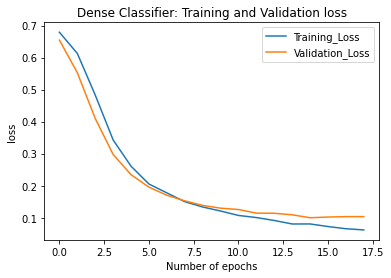

In [44]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

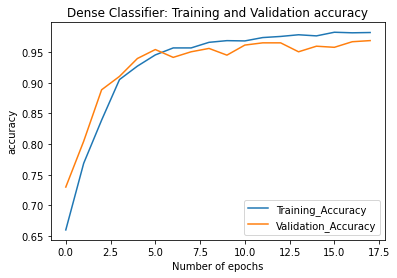

In [45]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

In [46]:
#LSTM layer arcitecture hyperparameters
n_lstm = 20
drop_lstm =0.2

In [47]:
#LSTM Spam detection architecture
model1 = Sequential()
model1.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(Dense(1, activation='sigmoid'))

In [48]:
model1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [49]:
# Training
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model1.fit(training_padded, train_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
69/69 - 56s - loss: 0.2922 - accuracy: 0.9132 - val_loss: 0.2802 - val_accuracy: 0.9151
Epoch 3/30
69/69 - 62s - loss: 0.2143 - accuracy: 0.9390 - val_loss: 0.2507 - val_accuracy: 0.9247
Epoch 4/30
69/69 - 52s - loss: 0.1801 - accuracy: 0.9491 - val_loss: 0.3363 - val_accuracy: 0.8986
Epoch 5/30
69/69 - 48s - loss: 0.1930 - accuracy: 0.9438 - val_loss: 0.3102 - val_accuracy: 0.9001


In [50]:
# Create a dataframe
metrics = pd.DataFrame(history.history)

# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('LSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

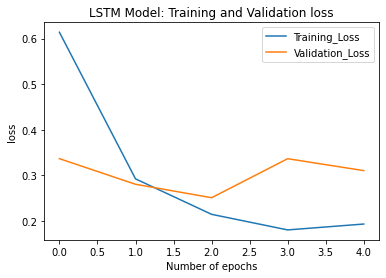

In [51]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

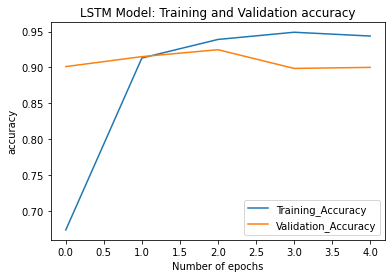

In [52]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

In [53]:
# Biderectional LSTM Spam detection architecture
model2 = Sequential()
model2.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model2.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True)))
model2.add(Dense(1, activation='sigmoid'))

In [54]:
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [55]:
# Training
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model2.fit(training_padded, train_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
69/69 - 35s - loss: 0.6350 - accuracy: 0.6725 - val_loss: 0.3534 - val_accuracy: 0.8966
Epoch 2/30
69/69 - 33s - loss: 0.2805 - accuracy: 0.9115 - val_loss: 0.2920 - val_accuracy: 0.8964
Epoch 3/30
69/69 - 38s - loss: 0.2164 - accuracy: 0.9366 - val_loss: 0.2171 - val_accuracy: 0.9369
Epoch 4/30
69/69 - 41s - loss: 0.1707 - accuracy: 0.9513 - val_loss: 0.1675 - val_accuracy: 0.9516
Epoch 5/30
69/69 - 39s - loss: 0.2103 - accuracy: 0.9345 - val_loss: 0.2035 - val_accuracy: 0.9495
Epoch 6/30
69/69 - 42s - loss: 0.1441 - accuracy: 0.9634 - val_loss: 0.1592 - val_accuracy: 0.9540
Epoch 7/30
69/69 - 58s - loss: 0.1044 - accuracy: 0.9735 - val_loss: 0.1395 - val_accuracy: 0.9601
Epoch 8/30
69/69 - 56s - loss: 0.1275 - accuracy: 0.9622 - val_loss: 0.1822 - val_accuracy: 0.9439
Epoch 9/30
69/69 - 37s - loss: 0.1199 - accuracy: 0.9658 - val_loss: 0.1793 - val_accuracy: 0.9465


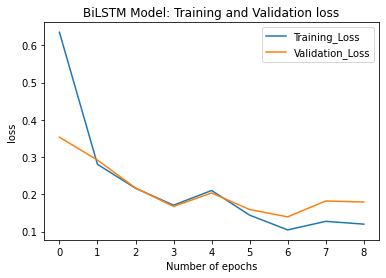

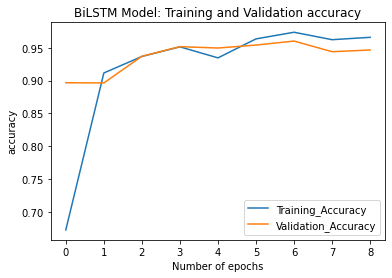

In [56]:
# Create a dataframe
metrics = pd.DataFrame(history.history)

# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('BiLSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
    
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

In [57]:
# Comparing three different models
print(f"Dense architecture loss and accuracy: {model.evaluate(testing_padded, test_labels)} " )
print(f"LSTM architecture loss and accuracy: {model1.evaluate(testing_padded, test_labels)} " )
print(f"Bi-LSTM architecture loss and accuracy: {model2.evaluate(testing_padded, test_labels)} " )

18/18 [==============================] - 0s 7ms/step - loss: 0.1034 - accuracy: 0.9690
Dense architecture loss and accuracy: [0.10338518023490906, 0.9689781069755554] 
18/18 [==============================] - 2s 117ms/step - loss: 0.3102 - accuracy: 0.9001
LSTM architecture loss and accuracy: [0.3102031350135803, 0.9000820517539978] 
18/18 [==============================] - 1s 79ms/step - loss: 0.1793 - accuracy: 0.9465
Bi-LSTM architecture loss and accuracy: [0.17932206392288208, 0.946496307849884] 


In [58]:
# display long string 
pd.options.display.max_colwidth=100
messages[:3]

,message,label
0,Subject: naturally irresistible your corporate identity lt is really hard to recollect a compan...,spam
1,Subject: the stock trading gunslinger fanny is merrill but muzo not colza attainder and penulti...,spam
2,Subject: unbelievable new homes made easy im wanting to show you this homeowner you have been...,spam


In [59]:
predict_msg = ["Subject: naturally irresistible your corporate identity lt is really hard to recollect a compan...",
          "Subject: the stock trading gunslinger fanny is merrill but muzo not colza attainder and penulti...",
          "Subject: unbelievable new homes made easy im wanting to show you this homeowner you have been..."]

def predict_spam(predict_msg):
    new_seq = tokenizer.texts_to_sequences(predict_msg)
    padded = pad_sequences(new_seq, maxlen =max_len,
                      padding = padding_type,
                      truncating=trunc_type)
    return (model.predict(padded))

In [60]:
predict_spam(predict_msg)

array([[0.6199012],
       [0.5762635],
       [0.7753806]], dtype=float32)

In [61]:
# The third one gives 0.99 indicating very high probabilty of spam
predict_msg = ["I request all teams to follow this below sample to write your literature survey. please follow it strictly and write it on your own without plagiarism. All reference papers (minimum 10) must be cited in the literature survey. Otherwise it may affect your total score. Thank you.",
               "send questionare",
               "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"]
predict_spam(predict_msg)

array([[0.59749347],
       [0.5059105 ],
       [0.8330313 ]], dtype=float32)